In [73]:
import time
import random

# Graphs

## Probability distribution

[1, 2, 3]
[0.40600584970983794, 0.6766764161830634, 0.857123460498547]


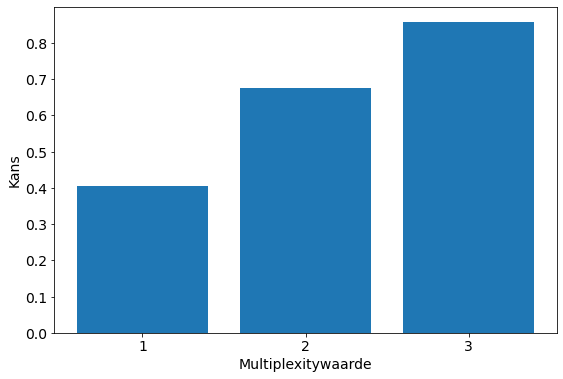

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
plt.rcParams.update({'font.size': 14})

float_range_array = [ 1, 2, 3 ]
values = []

index = 0
for i in float_range_array:
        values.append(poisson.cdf(float_range_array[index], lam))
        index += 1

print(float_range_array)
print(values)

plt.figure(figsize=(9,6))
plt.xticks([ 1, 2, 3 ])
plt.xlabel("Multiplexitywaarde")
plt.ylabel("Kans")
#plt.title("Voorbeeldkansverdeling for multiplexityvariantuitwisseling met gemiddelde multiplexitywaarde = 2\n(cumulatieve distributiefunctie voor een poissonverdeling met lambda = 2)")
plt.bar(float_range_array, values)
plt.savefig("probability.svg")

### Max neighbour distribution

In [91]:
class Link:
    def __init__(self, ends, multiplexity):
        self.ends = ends # e.g. [1, 4], [6, 2]\n",
        self.multiplexity = multiplexity # e.g. 1, 3, 5"

In [116]:
class NetworkedLinkGenerator():
    def __init__(self, friendly_name):
        self.friendly_name = friendly_name
    
    def attach_model(self, model):
        self.model = model
        
        self.links = []
        self.neighbourhood = { str(agent_id):[] for agent_id in range(self.model.num_agents) }
        self.multiplexity_list = { str(agent_id):{} for agent_id in range(self.model.num_agents) }
        
        # Register when this Networked Link Generator was summoned
        # We can use this to check how long the generation took
        self.starting_time = time.time()
        
    # This method facilitates the addition of links by abstracting it.
    # The addition of multiplexity is also handled here.
    def add_link(self, to_id, from_id):
        multiplexity = self.generate_multiplexity()
        
        # Add link
        self.links.append(Link([ to_id, from_id ], multiplexity))
        
        # Add neighbourhood information
        self.add_neighbour(to_id, [ from_id ])
        self.add_neighbour(from_id, [ to_id ])
        
        # Add multiplexity information
        self.add_multiplexity(to_id, from_id, multiplexity)
        self.add_multiplexity(from_id, to_id, multiplexity)
    
    # The structure of the neighbourhood is as follows:
    # agent_id: [ agent_ids of neighbours ]
    def add_neighbour(self, agent_id, neighbours):
        self.neighbourhood[str(agent_id)] = self.neighbourhood[str(agent_id)] + neighbours
    
    # The structure of the multiplexity list is as follows:
    # agent_id: { neighbour_id: multiplexity }
    def add_multiplexity(self, agent_id, neighbour_id, multiplexity):
        self.multiplexity_list[str(agent_id)][str(neighbour_id)] = multiplexity
    
    def generate_multiplexity(self):
        return random.randint(1, 3)
    
    # Shim for NetworkX's 'neighbors' method
    def neighbours(self, agent_id):          
        return self.neighbourhood[str(agent_id)]
    
    def multiplexity(self, agent_id, neighbour_id):
        return self.multiplexity_list[str(agent_id)][str(neighbour_id)]
    
    def has_link(self, from_id, to_id):
        from_neighbours = self.neighbours(from_id)
        return (to_id in from_neighbours)
    
    def compute_neighbourhood_distribution(self):
        self.neighbour_distribution = [ len(self.neighbours(agent)) for agent in range(0, self.model.num_agents) ]
        self.neighbour_distribution.sort()
        
        self.minimum_neighbours = min(self.neighbour_distribution)
        self.maximum_neighbours = max(self.neighbour_distribution)
        
    def compute_average_multiplexity(self):
        multiplexity_list = [ link.multiplexity for link in self.links ]
        self.average_multiplexity = sum(multiplexity_list) / len(multiplexity_list) 
        
    def finish_initialisation(self):
        self.compute_average_multiplexity()
        self.compute_neighbourhood_distribution()
        
        print("Maximum neighbours: {}".format(self.maximum_neighbours))
        
        generation_time = time.time() - self.starting_time

In [117]:
# This code is based on the NetworkX implementation:
# https://networkx.github.io/documentation/networkx-1.9.1/_modules/networkx/generators/random_graphs.html#powerlaw_cluster_graph
class HolmeKimNetwork(NetworkedLinkGenerator):
    def __init__(self, p):
        super().__init__("Holme and Kim network")
        self.p = p

    def attach_model(self, model):
        print("Initialising Holme and Kim network")
        super().attach_model(model)
        
        repeated_nodes = list(range(self.model.num_edges))  # list of existing m initial nodes to sample from
                                                      # with nodes repeated once for each adjacent edge
        
        source = self.model.num_edges # next node is m
        while source < self.model.num_agents: # Now add the other n-1 nodes
            possible_targets = self._random_subset(repeated_nodes, self.model.num_edges)
            
            # Do one preferential attachment for new node
            target = possible_targets.pop()
            self.add_link(source, target)
            
            repeated_nodes.append(target) # add one node to list for each new link
            
            count = 1
            while count < self.model.num_edges:  # add m-1 more new links
                if random.random() < self.p: # clustering step: add triangle
                    neighborhood = [nbr for nbr in iter(self.neighbours(target)) \
                                   if not self.has_link(source, nbr) \
                                   and not nbr == source]
                    
                    if neighborhood: # if there is a neighbor without a link
                        nbr = random.choice(neighborhood)
                        self.add_link(source, nbr) # add triangle
                        repeated_nodes.append(nbr)
                        count = count + 1
                        continue # go to top of while loop
                        
                # else do preferential attachment step if above fails
                target = possible_targets.pop()
                self.add_link(source, target)
                repeated_nodes.append(target)
                count = count + 1 
                
            repeated_nodes.extend([source]* self.model.num_edges)  # add source node to list m times
            source += 1
        
        self.finish_initialisation()
    
    # Return m unique elements from seq
    def _random_subset(self, seq, m):
        targets=set()
        while len(targets)<m:
            x=random.choice(seq)
            targets.add(x)
        return targets


In [ ]:
x_axis = []
y_axis = []

class ModelShim:
    def __init__(self, num_agents, num_edges):
        self.num_agents = num_agents
        self.num_edges = num_edges

for i in range(1, 16):
    print("num_edges =", i)
    for j in range(0, 50):
        hk = HolmeKimNetwork(0.95)
        hk.attach_model(ModelShim(1000, i))
        
        x_axis.append(i)
        y_axis.append(hk.maximum_neighbours)

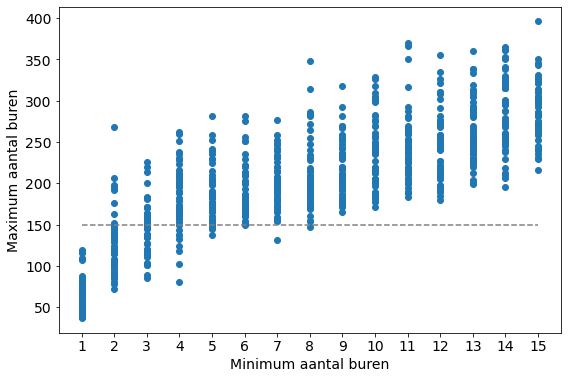

In [182]:
plt.figure(figsize=(9,6))
plt.xticks(range(1, 16, 1))
plt.xlabel("Minimum aantal buren")
plt.ylabel("Maximum aantal buren")
#plt.title("Distributie van het maximaal aantal buren in een Holme en Kim-netwerk (1000 agents)\nstippellijn = cognitieve limiet\nbolletje = één gegenereerd netwerk")
plt.hlines(150, 1, 15, linestyles='dashed', colors="grey")
plt.scatter(x_axis, y_axis)
plt.savefig("neighbour_distribution.svg")

## Agent distribution

In [ ]:
x_axis_agent = []
y_axis_agent = []

class ModelShim:
    def __init__(self, num_agents, num_edges):
        self.num_agents = num_agents
        self.num_edges = num_edges

for i in range(250, 10001, 250):
    print("agents =", i)
    for j in range(0, 50):
        hk = HolmeKimNetwork(0.95)
        hk.attach_model(ModelShim(i, 1))
        
        x_axis_agent.append(i)
        y_axis_agent.append(hk.maximum_neighbours)

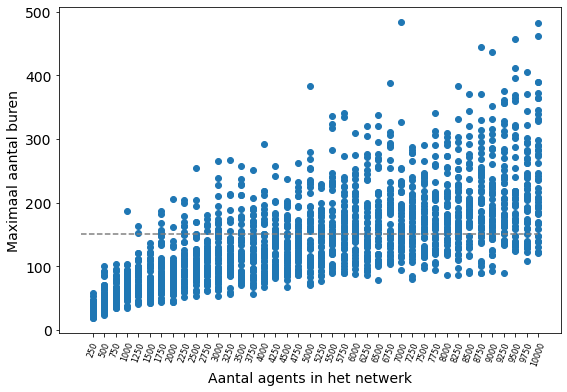

In [186]:
plt.figure(figsize=(9,6))
plt.rc('xtick', labelsize=8) 
plt.xticks(range(250, 10001, 250), rotation=70)
plt.xlabel("Aantal agents in het netwerk")
plt.ylabel("Maximaal aantal buren")
#plt.title("Distributie van het maximaal aantal buren in een Holme en Kim-netwerk (minimum aantal buren = 1)\nstippellijn = cognitieve limiet\nbolletje = één gegenereerd netwerk")
plt.hlines(150, 1, 10000, linestyles='dashed', colors="grey")
plt.scatter(x_axis_agent, y_axis_agent)
plt.savefig("agent_distribution.svg")